In [112]:
import json
import joblib
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer

import catboost
import torch

# Задание - Предсказание уровня экспресси белка

<img src='https://www.researchgate.net/publication/313504607/figure/fig3/AS:459880453677066@1486655453033/Protein-protein-interaction-PPI-network-of-DEGs-by-STRING-The-interaction-score-was.png'>




<div class="alert alert-info">
<b>Про биологию</b>
    
Экспрессия — процесс, в ходе которого наследственная информация от гена (последовательности нуклеотидов ДНК) преобразуется в функциональный продукт — белок. Уровнем экспрессии называют - количество белка, производящегося в этом процессе. Чем выше экспрессия белка, тем большее количество этого белка появляется в клетках человека. 
    
    

<div class="alert alert-info">    
<b>Важность задачи</b>
    
Существует множество причин необходимости в знании уровня экспресии белка. Например - это позволяет ученым разрабатывать лекарственные средства и оптимизировать их разработку. Теперь вам предстоит побыть в роли биоинформатика и помочь науке!
    
</div>


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой граф взаимойдествия белков. Где узлы это белки, взаимодействие между белками это ребро. 

Для каждого белка известен уровень его экспрессии. Ниже приведен список ребер `edges`. Информация по экспрессии белков, разбитая на `train` и `test`.
   
    
</div>

In [2]:
#Список ребер графа 

edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",") # Подгрузим данные
edges.head()

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986


In [3]:
#Подгрузим тренирочную выборку
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",") # Подгрузим данные
train.head()

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721


In [4]:
# Подгрузим отложенную выборку для валидации
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")
test.head()

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125


<div class="alert alert-info">
<b>Про Задачу</b>
    
Вам предлагается предсказать экспрессию белков (`target`) по приведенным данным для отложенной выборки. Ответы в отложенной выборке `test` даны вам для самостоятельной валидации.


    
   
    

<div class="alert alert-info">
<b>Замечание и комментарии</b>
    
    

По ряду причин датасет был упрощен так, чтобы выполнялись следующие условия:
* у графа одна компонента связанности. 
* удалены слишком крупные хабы
* плотность связей графа уменьшена
* решить задачу можно классическими ML подходами
    
   

<div class="alert alert-info">
<b>Оценка результатов</b>
    


Оценка точности модели будет оцениваться по метрике MSE на отложенной выборке `test`
        
</div>

<div class="alert alert-info">
<b>Автор задачи</b>

По всем дополнительным вопросами писать Александру Миленькину
* Телеграмм: Alerin75infskin
* Почта: milenkin.aa@phystech.edu
        
</div>

### Approach description

1. Экспрессиия - характеристика белка. В свою очередь, белок можно представить в виде узла графа, где рёбрами будут взаимодействия между белками.
1. Логичным подходом для построения классической ML-модели будет генерация признаков узлов в графе
1. Для этого можно использовать следующие характеристики:
    * коэффициент кластеризации для узла
    * степень узла
    * меры центральности
        * degree centrality
        * betweennes centrality
        * closeness centrality
        * eignvector centrality
        * information centrality
    * количество клик, в которые входит узел
    * размер максимальной клики, в которую входит узел
    * входит ли узел в мосты графа и т.д.
1. В результате, можно построить алгоритм, решающий задачу регрессии

### Make graph

In [7]:
edges.shape

(594174, 2)

In [8]:
gr = nx.Graph()
gr.add_edges_from(edges.to_numpy())

In [9]:
gr.number_of_edges()

594174

In [10]:
len(gr.nodes())

10000

### Draw graph

In [11]:
nodes_mapping = {k: node for k, node in enumerate(sorted(gr.nodes()))}
nodes_mapping_rev = {node: k for k, node in enumerate(sorted(gr.nodes()))}

In [ ]:
# некоторые параметры визауализации графа
node_size = 600
with_labels=True
node_color="r"
# отрисовка графа
plt.figure(figsize=(10,10))
nx.draw_networkx(gr,
                 pos=nx.kamada_kawai_layout(gr), # вариант макета укладки графа
                 with_labels=with_labels, # добавление меток к варшинам графа
                 node_size=node_size, # размер узлов
                 node_color=node_color, # цвет узлов
                 labels=nodes_mapping_rev # маркировка вершин их атрибутами
                 )
plt.axis("off")
plt.show()

К сожалению, из-за размера графа отрисовка будет идти долго :(

### Make features

#### Степень узла

In [70]:
degrees = dict(gr.degree)
degrees = dict(sorted(degrees.items(), key=lambda x: x[0]))

#### Кластерный коэффициент

In [72]:
clustering_coefs = nx.clustering(gr)
clustering_coefs = dict(sorted(clustering_coefs.items(), key=lambda x: x[0]))

#### Degree centrality

In [152]:
degree_centrality = nx.degree_centrality(gr)
degree_centrality = dict(sorted(degree_centrality.items(), key=lambda x: x[0]))

#### Betweenness centrality

In [181]:
betweenness_centrality = nx.betweenness_centrality(gr)
betweenness_centrality = dict(sorted(betweenness_centrality.items(), key=lambda x: x[0]))

#### Closeness centrality

In [183]:
closeness_centrality = nx.closeness_centrality(gr)
closeness_centrality = dict(sorted(closeness_centrality.items(), key=lambda x: x[0]))

#### Eigenvector centrality

In [584]:
eigenvector_centrality = nx.eigenvector_centrality(gr)
eigenvector_centrality = dict(sorted(eigenvector_centrality.items(), key=lambda x: x[0]))

#### Information centrality

In [603]:
information_centrality = nx.current_flow_closeness_centrality(gr)
information_centrality = dict(sorted(information_centrality.items(), key=lambda x: x[0]))

#### Клики

In [12]:
cliques = list(nx.find_cliques(gr))

In [13]:
cliques[:10]

[[0, 20480, 1538],
 [0, 20480, 9747, 569],
 [0, 20480, 27432],
 [0, 20480, 13628, 1378, 574],
 [0, 20480, 13628, 1768],
 [0, 20480, 13628, 2122],
 [0, 20480, 13628, 2898],
 [0, 20480, 13628, 569, 1309],
 [0, 20480, 13628, 2204],
 [0, 20480, 4031]]

#### Количество клик, в которые входит узел + размер максимальной клики для каждого узла

In [14]:
cnt_cliques = {}
max_cliques = {}
for cl in tqdm(cliques):
    for n in cl:
        len_cl = len(cl)
        curr_cnt = cnt_cliques.get(n, 0)
        curr_max = max_cliques.get(n, 0)
        if len_cl > curr_max:
            max_cliques[n] = len_cl
        cnt_cliques[n] = curr_cnt + 1
cnt_cliques = dict(sorted(cnt_cliques.items(), key=lambda x: x[0]))
max_cliques = dict(sorted(max_cliques.items(), key=lambda x: x[0]))

100%|██████████| 1266891/1266891 [00:03<00:00, 326798.18it/s]


In [15]:
len(max_cliques), len(cnt_cliques)

(10000, 10000)

#### Мосты

In [17]:
bridges = list(nx.bridges(gr))

In [18]:
bridges

[]

В графе нет мостов

#### Сообщества

In [ ]:
community = list(nx.algorithms.community.girvan_newman(gr))

Из-за размера графа и вычислительной сложности подсчёт сообществ займёт долгое время. Пока не будем использовать.

#### Компоненты связанности

In [21]:
conn_components = list(nx.connected_components(gr))

In [23]:
len(conn_components)

1

In [24]:
len(conn_components[0])

10000

В графе всего лишь один связанный компонент, куда входят все узлы

#### Make dataset from relevant features

In [ ]:
features = {
                                                    'degree': degrees.values(),
                                                    'clustering_coef': clustering_coefs.values(),
                                                    'degree_centrality': degree_centrality.values(),
                                                    'betweenness_centrality': betweenness_centrality.values(),
                                                    'closeness_centrality': closeness_centrality.values(),
                                                    'eigenvector_centrality': eigenvector_centrality.values(),
                                                    'information_centrality': information_centrality.values(),
                                                    'cnt_cliques': cnt_cliques.values(),
                                                    'max_cliques': max_cliques.values(),
                                                }
features_full = {
                                                    'degree': degrees,
                                                    'clustering_coef': clustering_coefs,
                                                    'degree_centrality': degree_centrality,
                                                    'betweenness_centrality': betweenness_centrality,
                                                    'closeness_centrality': closeness_centrality,
                                                    'eigenvector_centrality': eigenvector_centrality,
                                                    'information_centrality': information_centrality,
                                                    'cnt_cliques': cnt_cliques,
                                                    'max_cliques': max_cliques,
                                                }

In [ ]:
data = pd.DataFrame(index=degrees.keys(), data=features)

#### Save dataset

In [778]:
joblib.dump(features_full, './data/extracted_features.pkl')

['./data/extracted_features.pkl']

In [ ]:
data.to_csv('./data/data_prepared.csv', index=False)

#### Load features

In [27]:
data = pd.read_csv('./data/data_prepared.csv')

In [30]:
extracted_features = joblib.load('./data/extracted_features.pkl')

In [734]:
data = pd.DataFrame(index=extracted_features.get('degree').keys(), data={name: [v for v in dd.values()] for name, dd in extracted_features.items()})

### Features analysis

In [735]:
data

,degree,clustering_coef,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,information_centrality,cnt_cliques,max_cliques
0,1863,0.013900,0.186319,0.010784,0.551274,0.071758,0.007028,25362,8
1,804,0.036914,0.080408,0.002156,0.519078,0.038140,0.006692,14374,7
2,1709,0.014655,0.170917,0.007632,0.546244,0.069276,0.007003,25369,8
3,55,0.111785,0.005501,0.000014,0.440873,0.003467,0.003124,128,5
4,52,0.025641,0.005201,0.000009,0.394360,0.002144,0.003023,49,4
...,...,...,...,...,...,...,...,...,...
31175,42,0.011614,0.004200,0.000008,0.383559,0.001560,0.002654,41,3
31178,206,0.006583,0.020602,0.000150,0.432333,0.006553,0.005375,223,4
31179,47,0.031452,0.004700,0.000005,0.383397,0.002239,0.002841,48,4
31193,90,0.014232,0.009001,0.000021,0.403886,0.003852,0.004014,103,3


#### Корреляции

Избавимся от скоррелированных фичей

In [736]:
corr = data.corr()

In [737]:
corr.style.background_gradient(cmap='coolwarm')

,degree,clustering_coef,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,information_centrality,cnt_cliques,max_cliques
degree,1.000000,-0.212480,1.000000,0.870482,0.576371,0.917283,0.722412,0.776371,0.485445
clustering_coef,-0.212480,1.000000,-0.212480,-0.134779,0.330783,0.051441,-0.197566,-0.069533,0.452767
degree_centrality,1.000000,-0.212480,1.000000,0.870482,0.576371,0.917283,0.722412,0.776371,0.485445
betweenness_centrality,0.870482,-0.134779,0.870482,1.000000,0.368194,0.768685,0.404449,0.852784,0.312556
closeness_centrality,0.576371,0.330783,0.576371,0.368194,1.000000,0.750191,0.741163,0.359052,0.808274
eigenvector_centrality,0.917283,0.051441,0.917283,0.768685,0.750191,1.000000,0.739417,0.735649,0.698020
information_centrality,0.722412,-0.197566,0.722412,0.404449,0.741163,0.739417,1.000000,0.381910,0.616684
cnt_cliques,0.776371,-0.069533,0.776371,0.852784,0.359052,0.735649,0.381910,1.000000,0.348171
max_cliques,0.485445,0.452767,0.485445,0.312556,0.808274,0.698020,0.616684,0.348171,1.000000


Уберём колонки, для которых коэффициенты корреляции выше порога

In [738]:
THRESH_CORR = 0.95

In [739]:
corr_upper = np.triu(corr.to_numpy()) - np.eye(corr.shape[1])

In [740]:
cols_0 = np.unique(np.argwhere(corr_upper >= THRESH_CORR)[:,0])
cols_1 = np.unique(np.argwhere(corr_upper >= THRESH_CORR)[:,1])
ind_col_corr = cols_0 if len(cols_0) <= len(cols_1) else cols_1

In [741]:
ind_col_corr

array([0], dtype=int64)

Очевидно, что degree и degree_centrality, по сути, являются одной и той же характеристикой, поэтому можно удалить одну из них

In [742]:
cols_corr = data.iloc[:, ind_col_corr].columns

In [743]:
cols_corr

Index(['degree'], dtype='object')

In [744]:
data = data.drop(columns=cols_corr)

#### Train/test split

In [745]:
X_train = data[data.index.isin(train.node)].sort_index()
y_train = train.sort_values('node').set_index('node').target
X_test = data[data.index.isin(test.node)]
y_test = test.sort_values('node').set_index('node').target

In [746]:
X_train

,clustering_coef,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,information_centrality,cnt_cliques,max_cliques
0,0.013900,0.186319,0.010784,0.551274,0.071758,0.007028,25362,8
1,0.036914,0.080408,0.002156,0.519078,0.038140,0.006692,14374,7
2,0.014655,0.170917,0.007632,0.546244,0.069276,0.007003,25369,8
3,0.111785,0.005501,0.000014,0.440873,0.003467,0.003124,128,5
4,0.025641,0.005201,0.000009,0.394360,0.002144,0.003023,49,4
...,...,...,...,...,...,...,...,...
31175,0.011614,0.004200,0.000008,0.383559,0.001560,0.002654,41,3
31178,0.006583,0.020602,0.000150,0.432333,0.006553,0.005375,223,4
31179,0.031452,0.004700,0.000005,0.383397,0.002239,0.002841,48,4
31193,0.014232,0.009001,0.000021,0.403886,0.003852,0.004014,103,3


#### Outliers

Можно попробовать избавиться от выбросов. Однако, в данной задаче это ощутимо уменьшает тренировочный датасет. Поэтому лучше не выкидывать выбросы, а использовать масштабирование фичей с помощью StandardScaler или MinMaxScaler

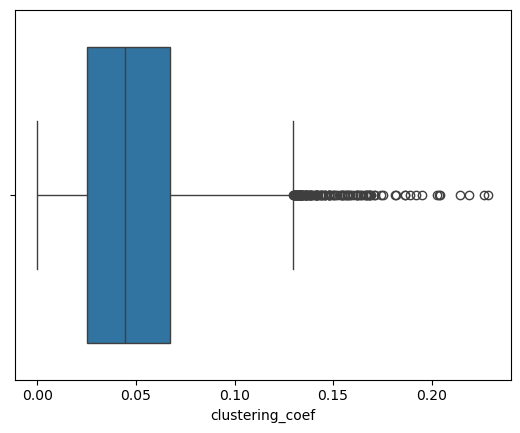

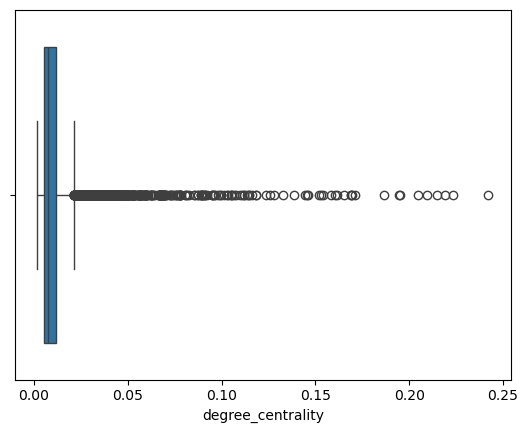

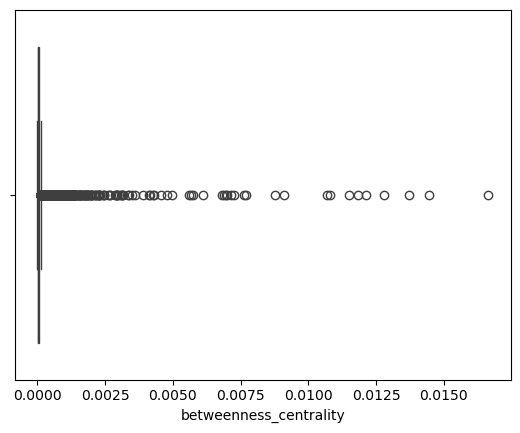

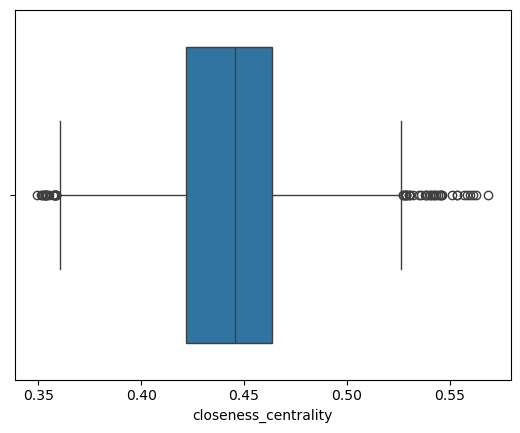

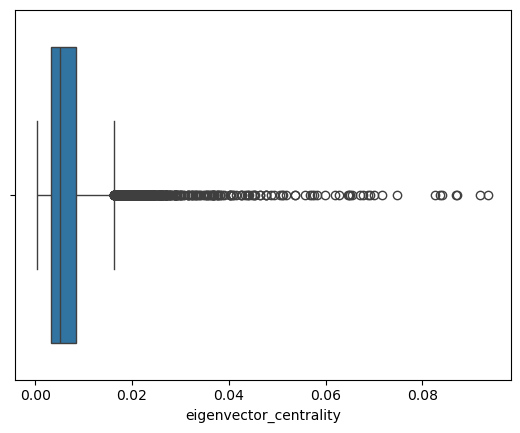

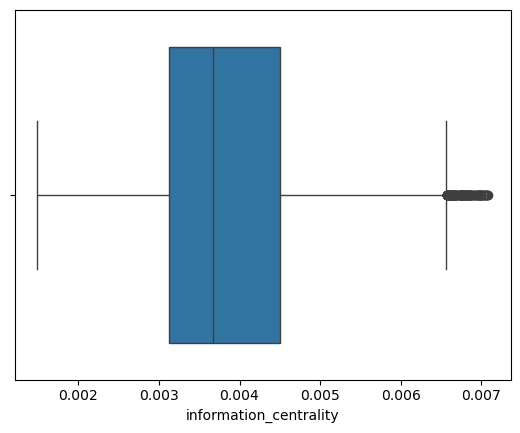

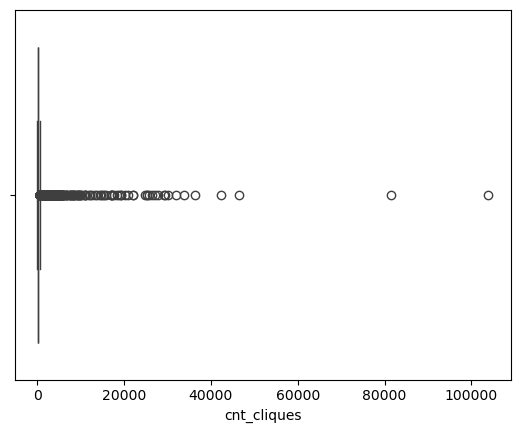

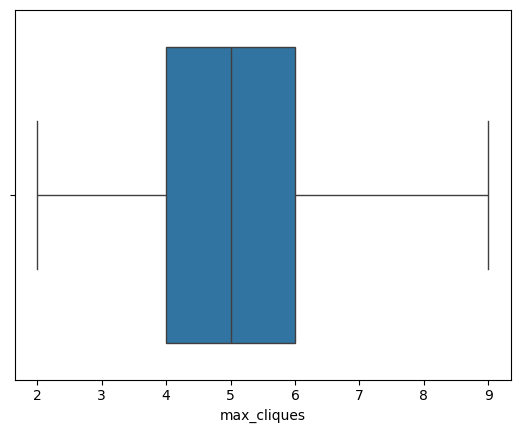

In [747]:
for col in X_train.columns:
    sns.boxplot(X_train, x=col)
    plt.show();

In [315]:
def filter_outliers(X, y, pr_l=0.25, pr_u=0.75):
    for col in X.columns:
        q_l = X_train[col].quantile(q=pr_l)
        q_u = X_train[col].quantile(q=pr_u)
        X = X.query(f'@q_l <= {col} <= @q_u')
    return X, y[X.index]

In [564]:
X_train, y_train = filter_outliers(X_train, y_train, pr_l=0, pr_u=0.99)

In [565]:
X_train.shape

(7802, 8)

#### Train

Рассмотрим несколько различных алгоритмов:   
* линейная регрессия
* elastic net (линейная регрессия+L1+L2)
* случайный лес
* бустинг на деревьях (catboost)
* SVR (метод опорных векторов для регрессии)

In [748]:
bin_d = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')

lr = LinearRegression(
                        fit_intercept=True,
                        )
el_n = ElasticNet(
                    alpha=0.2,
                    l1_ratio=0.3,
                    max_iter=100
)

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    # max_features=2,
    # min_samples_split=2,
    # min_samples_leaf=4,
    random_state=42,
)

svr = SVR()

cb = catboost.CatBoostRegressor(
                                    iterations=400,
                                    objective='RMSE',
                                    max_depth=6,
                                    colsample_bylevel=0.3,
                                    random_strength=2,
                                    # l2_leaf_reg=2,
                                    verbose=False,
                                    )

models_items = [
                            ('linear regression', lr),
                            ('elastic net', el_n),
                            ('random forest', rf),
                            ('catboost', cb),
                            ('SVR', svr),
]

In [749]:
def train_model(X, y, model, scaler=None):
    if scaler:
        pipeline = [('scaler', scaler)]
    else:
        pipeline = []
    pipeline.append(model)
    pipeline = Pipeline(pipeline)
    pipeline.fit(X, y)
    return pipeline

def train_all_models(X, y, models_items, scaler=StandardScaler()):
    fit_models = {}
    for name, model in models_items:
        if name in ['linear regression', 'elastic net', 'SVR']:
            model = train_model(X, y, (name, model), scaler=scaler)
        else:
            model = train_model(X, y, (name, model), scaler=None)
        fit_models[name] = model
    return fit_models

def evaluate(model, X, y_true, model_type='sklearn'):
    if model_type == 'sklearn': 
        y_pred = model.predict(X)
    else:
        y_pred = model.eval()(X).detach().numpy()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        "MAE": round(mae, 3),
        "MSE": round(mse, 3),
        "RMSE": round(rmse, 3),
        "R2": round(r2, 3),
    }

def evaluate_all(models, X, y_true, model_type='sklearn'):
    metrics = {}
    for name, model in models.items():
        metrics[name] = evaluate(model, X, y_true, model_type)
    return metrics

In [750]:
fit_models = train_all_models(X_train, y_train, models_items, scaler=StandardScaler())

#### Metrics train

In [751]:
metrics_train = pd.DataFrame(evaluate_all(fit_models, X_train, y_train))

In [752]:
metrics_train

,linear regression,elastic net,random forest,catboost,SVR
MAE,0.054,0.087,0.041,0.043,0.058
MSE,0.008,0.025,0.003,0.004,0.033
RMSE,0.092,0.157,0.058,0.062,0.183
R2,0.981,0.946,0.993,0.992,0.926


#### Metrics test

In [753]:
metrics_test = pd.DataFrame(evaluate_all(fit_models, X_test, y_test))

In [754]:
metrics_test

,linear regression,elastic net,random forest,catboost,SVR
MAE,0.054,0.092,0.052,0.053,0.074
MSE,0.010,0.038,0.015,0.019,0.123
RMSE,0.102,0.195,0.120,0.138,0.351
R2,0.986,0.949,0.981,0.975,0.836


### Neural net

Попробуем обучить простейшую fully-connected нейронку just for fun

In [755]:
X_train = torch.Tensor(StandardScaler().fit_transform(X_train))
y_train = torch.Tensor(y_train.to_numpy()).reshape((-1,1))
X_test = torch.Tensor(StandardScaler().fit_transform(X_test))
y_test = torch.Tensor(y_test.to_numpy()).reshape((-1,1))

In [756]:
class NeuralNet(torch.nn.Module):
    def __init__(self,
                    n_hidden_neurons: dict,
                    ):
        super().__init__()
        self.n_hidden_neurons = n_hidden_neurons
        self.blocks = []
        if isinstance(self.n_hidden_neurons, dict):
            for _, num_nn in self.n_hidden_neurons.items():            
                self.blocks.append(torch.nn.Linear(num_nn[0], num_nn[1]))  
                self.blocks.append(torch.nn.ReLU())
                self.blocks.append(torch.nn.Dropout(0.7))
            self.blocks.append(torch.nn.Linear(num_nn[1], 1))
        else:
            self.blocks.append(torch.nn.Linear(self.n_hidden_neurons, 1))
        self.core_layers = torch.nn.Sequential(*self.blocks)
    
    def forward(self, x):
        for block in self.core_layers:
            x = block(x)
        return x

In [757]:
# nn = NeuralNet(
#     {
#         '0': (X_train.shape[1], 10),
#         # '1': (100, 10)
#     }
# )
nn = NeuralNet(X_train.shape[1])
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn.parameters(), lr=1e-03)

In [758]:
nn

NeuralNet(
  (core_layers): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [759]:
BATCH_SIZE = 128
EPOCHS = 60

In [760]:
for iteration in range(EPOCHS):
    order = np.random.permutation(X_train.shape[0])
    X_train = X_train[order]
    y_train = y_train[order]
    num_batches = X_train.shape[0] // BATCH_SIZE
    for batch in range(0, num_batches + 1):
        X_batch = X_train[batch*BATCH_SIZE:(batch + 1)*BATCH_SIZE]
        y_batch = y_train[batch*BATCH_SIZE:(batch + 1)*BATCH_SIZE]            
        optimizer.zero_grad()                        
        preds = nn(X_batch)
        loss_batch = loss(preds, y_batch)
        loss_batch.backward()
        optimizer.step()
    if iteration % 10 == 0:
        with torch.no_grad():
            y_pred = nn(X_train)
            mse = mean_squared_error(y_train, y_pred)
            print(f"Epoch {iteration}, MSE: {mse}")
with torch.no_grad():
    y_test_pred = nn.eval()(X_test)
    y_train_pred = nn.eval()(X_train)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    print(f"MSE (train): {mse_train}")
    print(f"MSE (test): {mse_test}")


Epoch 0, MSE: 0.926544725894928
Epoch 10, MSE: 0.09223613142967224
Epoch 20, MSE: 0.039957161992788315
Epoch 30, MSE: 0.027009684592485428
Epoch 40, MSE: 0.02000257931649685
Epoch 50, MSE: 0.016006162390112877
MSE (train): 0.01364442054182291
MSE (test): 0.05980892479419708


In [761]:
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred)}")

print(f"Train MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred)}")

print(f"Train RMSE: {root_mean_squared_error(y_train, y_train_pred)}")
print(f"Test RMSE: {root_mean_squared_error(y_test, y_test_pred)}")

print(f"Train R2: {r2_score(y_train, y_train_pred)}")
print(f"Test R2: {r2_score(y_test, y_test_pred)}")

Train MAE: 0.072087861597538
Test MAE: 0.0910433679819107
Train MSE: 0.01364442054182291
Test MSE: 0.05980892479419708
Train RMSE: 0.11680933088064194
Test RMSE: 0.24455863237380981
Train R2: 0.9698720761088876
Test R2: 0.9204758306211185


In [765]:
metrics_nn_train = evaluate(nn, X_train, y_train.detach().numpy(), model_type='torch')
metrics_nn_test = evaluate(nn, X_test, y_test.detach().numpy(), model_type='torch')

In [766]:
metrics_train['NN'] = list(metrics_nn_train.values())
metrics_test['NN'] = list(metrics_nn_test.values())

### Final metrics

In [767]:
metrics_train

,linear regression,elastic net,random forest,catboost,SVR,NN
MAE,0.054,0.087,0.041,0.043,0.058,0.072
MSE,0.008,0.025,0.003,0.004,0.033,0.014
RMSE,0.092,0.157,0.058,0.062,0.183,0.117
R2,0.981,0.946,0.993,0.992,0.926,0.970


In [764]:
metrics_test

,linear regression,elastic net,random forest,catboost,SVR,NN
MAE,0.054,0.092,0.052,0.053,0.074,0.091
MSE,0.010,0.038,0.015,0.019,0.123,0.060
RMSE,0.102,0.195,0.120,0.138,0.351,0.245
R2,0.986,0.949,0.981,0.975,0.836,0.920


### Summary

1. С точки зрения MSE, RMSE, R2 на test выборке наиболее лучшим оказалась обычная линейная регрессия **(MSE=0.01)**
1. С другой стороны, такие алгоритмы на деревьях (random forest и catboost) также показывают неплохое качество, а некоторые метрики (MAE) даже чуть ниже на test
1. Для улучшения качества предсказаний можно:
    * добавить дополнительные фичи, основанные на характеристиках графа (например, принадлженость к сообществам), другие меры центральности и т.д.
    * более тщательно потюнить параметры использованных алгоритмов
    * возможно, более тщательно поработать с препроцессингом данных
    * использовать более продвинутые алгоритмы для работы с графами (например, графовые нейронки) 